In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import datetime as dt
import scipy.stats as stats

In [4]:
# Pull in hcdn_q_data from streamflowdata folder
hcdn_q_data = xr.open_dataset('../data/streamflowdata/hcdn_basin_chars_and_daily_q.nc')

# add a water year variable to the dataset
hcdn_q_data['water_year'] = hcdn_q_data.date.dt.year.where(hcdn_q_data.date.dt.month >= 10, hcdn_q_data.date.dt.year - 1)

# create a function to calculate the day of water year for each date in the dataset
def day_of_water_year_func(date):
    if date.month >= 10:
        return (date - pd.to_datetime(str(date.year) + '-10-01')).days + 1
    else:
        return (date - pd.to_datetime(str(date.year - 1) + '-10-01')).days + 1

# apply the function to the date variable to create a new variable
day_of_water_year = [day_of_water_year_func(date) for date in pd.to_datetime(hcdn_q_data.date.values)]

# add the day of water year variable to the dataset
hcdn_q_data['day_of_water_year'] = xr.DataArray(day_of_water_year, dims=['date'], coords={'date': hcdn_q_data.date})
                                                

In [25]:
# calculate the day of water year flow at each site
water_year_mean_flow = hcdn_q_data.groupby('day_of_water_year').mean()['00060_Mean']


In [26]:
# Zero is the mid elevation basins, 1 is the low elevation basins, and 2 are the high elevation basins
basin_elevation_groups = pd.read_csv('../data/geodata/basin_elevation_groups.csv', index_col=1).drop(columns='Unnamed: 0')
basin_elevation_groups.index =  ['0'+str(site) for site in basin_elevation_groups.index.values]
basin_group_da = basin_elevation_groups.to_xarray().rename({'index':'site_no'})

# merge basin_group_da into water_year_mean_flow
water_year_mean_flow = water_year_mean_flow.to_dataset(name='flow').merge(basin_group_da)

In [27]:
# calculate the mean flow for each predicted cluster and day of water year
water_year_cluster_flow = water_year_mean_flow.groupby('predicted_cluster').mean()

# change the predicted_cluster values from 0,1,2 to mid, low, high
water_year_cluster_flow['predicted_cluster'] = ['mid', 'low', 'high']


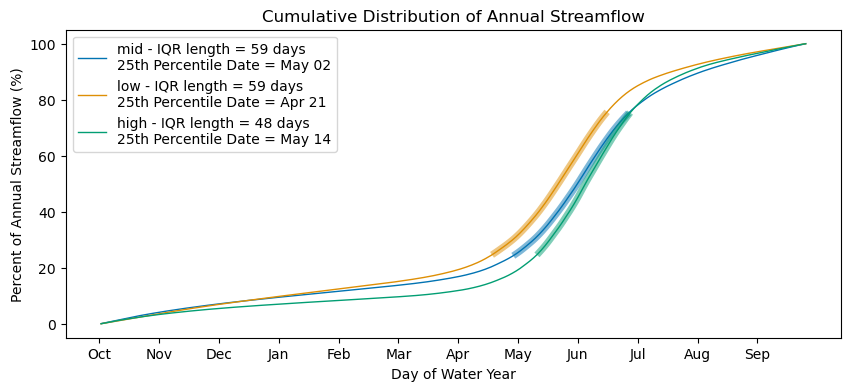

In [71]:
# create the figure
fig = plt.figure(figsize=(10,4))
# iterate through all sites and plot the above cumulative distribution
# create a list of colors, one for each site
colors = sns.color_palette('colorblind', len(water_year_cluster_flow.predicted_cluster))

for site in range(len(water_year_cluster_flow.predicted_cluster)):
    tmp_ds = (water_year_cluster_flow['flow'].cumsum(dim='day_of_water_year')/water_year_cluster_flow['flow'].sum(dim='day_of_water_year') * 100).isel(predicted_cluster=site)
    # find the day of water year for the 25th percentile
    iqr_25_index = tmp_ds.where(tmp_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index = tmp_ds.where(tmp_ds >= 75, drop=True).day_of_water_year.values[0]
    
    # Initializing start date
    strt_date = dt.date(int(2020), 1, 1)
    
    # converting to date
    res_date = strt_date + dt.timedelta(days=int(iqr_25_index-92) - 1)
    res = res_date.strftime("%b %d")

    # plot the cumulative distribution
    tmp_ds.plot(label=f'{water_year_cluster_flow.predicted_cluster.values[site]} - IQR length = {iqr_75_index - iqr_25_index} days\n25th Percentile Date = {res}', color=colors[site], lw=1)
    # create a filter for the inter quartile range
    iqr_filter = (tmp_ds >= 25) & (tmp_ds <= 75)
    # add a wider line for the interquartile range
    tmp_ds.where(iqr_filter, drop=True).plot(lw=5, alpha=0.5,color=colors[site],)
    
# make the x-axis a an axis of months
plt.xticks(np.arange(0,366,31),['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
# make the y-axis a percentage
plt.ylabel('Percent of Annual Streamflow (%)')
# remove the x-label
plt.xlabel('Day of Water Year')
# make the title "Cumulative Distribution of Annual Streamflow"
plt.title('Cumulative Distribution of Annual Streamflow')
plt.legend()

In [72]:
# calculate the day of water year flow at each site for pre- and post- 2000
water_year_mean_flow_pre_2000 = hcdn_q_data.where(hcdn_q_data.date.dt.year < 2000, drop=True).groupby('day_of_water_year').mean()['00060_Mean']
water_year_mean_flow_post_2000 = hcdn_q_data.where(hcdn_q_data.date.dt.year >= 2000, drop=True).groupby('day_of_water_year').mean()['00060_Mean']

# merge basin_group_da into water_year_mean_flow_pre_2000 and water_year_mean_flow_post_2000
water_year_mean_flow_pre_2000 = water_year_mean_flow_pre_2000.to_dataset(name='flow').merge(basin_group_da)
water_year_mean_flow_post_2000 = water_year_mean_flow_post_2000.to_dataset(name='flow').merge(basin_group_da)

# calculate the mean flow for each predicted cluster and day of water year for pre and post 2000
water_year_cluster_flow_pre_2000 = water_year_mean_flow_pre_2000.groupby('predicted_cluster').mean()
water_year_cluster_flow_post_2000 = water_year_mean_flow_post_2000.groupby('predicted_cluster').mean()

# change the predicted_cluster values from 0,1,2 to mid, low, high
water_year_cluster_flow_pre_2000['predicted_cluster'] = ['mid', 'low', 'high']
water_year_cluster_flow_post_2000['predicted_cluster'] = ['mid', 'low', 'high']

# change the order of predicted_cluster to low, mid, high
water_year_cluster_flow_pre_2000 = water_year_cluster_flow_pre_2000.reindex(predicted_cluster=['low', 'mid', 'high'])
water_year_cluster_flow_post_2000 = water_year_cluster_flow_post_2000.reindex(predicted_cluster=['low', 'mid', 'high'])

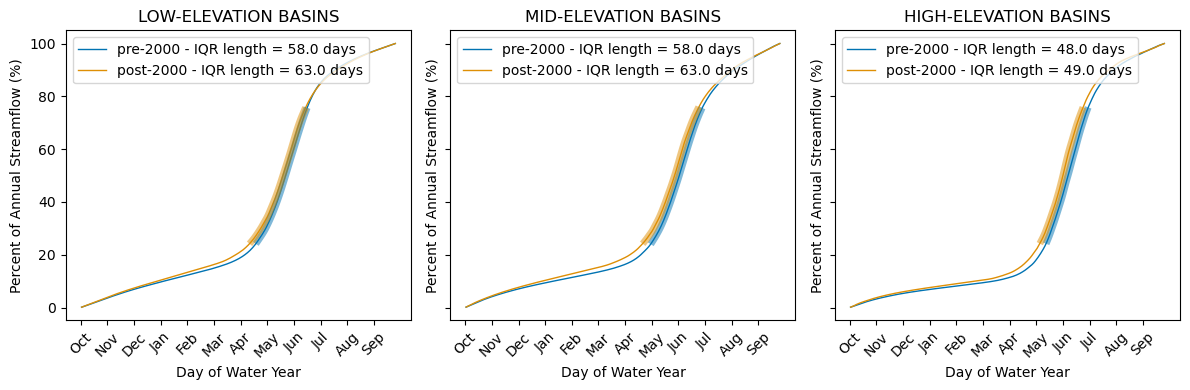

In [73]:
# create the figure
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True, tight_layout=True)
# iterate through all sites and plot the above cumulative distribution
# create a list of colors, one for each site
colors = sns.color_palette('colorblind', len(water_year_cluster_flow.predicted_cluster)+1)

for i,site in enumerate(water_year_cluster_flow_pre_2000.predicted_cluster):
    tmp_pre_ds = (water_year_cluster_flow_pre_2000['flow'].cumsum(dim='day_of_water_year')/water_year_cluster_flow_pre_2000['flow'].sum(dim='day_of_water_year') * 100).sel(predicted_cluster=site)
    tmp_post_ds = (water_year_cluster_flow_post_2000['flow'].cumsum(dim='day_of_water_year')/water_year_cluster_flow_post_2000['flow'].sum(dim='day_of_water_year') * 100).sel(predicted_cluster=site)
    
    # find the day of water year for the 25th percentile
    iqr_25_index_pre = tmp_pre_ds.where(tmp_pre_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index_pre = tmp_pre_ds.where(tmp_pre_ds >= 75, drop=True).day_of_water_year.values[0]

    # find the day of water year for the 25th percentile
    iqr_25_index_post = tmp_post_ds.where(tmp_post_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index_post = tmp_post_ds.where(tmp_post_ds >= 75, drop=True).day_of_water_year.values[0]
    
    # plot the pre-2000 and post-2000 cumulative distribution
    tmp_pre_ds.plot(label=f'pre-2000 - IQR length = {iqr_75_index_pre - iqr_25_index_pre} days', color=colors[0], lw=1, ax=axs[i], )
    tmp_post_ds.plot(label=f'post-2000 - IQR length = {iqr_75_index_post - iqr_25_index_post} days', lw=1, color=colors[1], ax=axs[i], )
    # create a filter for the inter quartile range
    iqr_pre_filter = (tmp_pre_ds >= 25) & (tmp_pre_ds <= 75)
    iqr_post_filter = (tmp_post_ds >= 25) & (tmp_post_ds <= 75) 
    # add a wider line for the interquartile range
    tmp_pre_ds.where(iqr_pre_filter, drop=True).plot(lw=5, alpha=0.5,color=colors[0], ax=axs[i])
    tmp_post_ds.where(iqr_post_filter, drop=True).plot(lw=5, alpha=0.5, color=colors[1], ax=axs[i])
    # make the x-axis a an axis of months
    axs[i].set_xticks(np.arange(0,366,31),['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
    # rotate the x-axis labels 45 degrees
    axs[i].tick_params(axis='x', rotation=45)
    # make the y-axis a percentage
    axs[i].set_ylabel('Percent of Annual Streamflow (%)')
    # set x-label
    axs[i].set_xlabel('Day of Water Year')
    # set title to the predicted cluster
    axs[i].set_title(f'{water_year_cluster_flow_pre_2000.predicted_cluster.values[i].upper()}-ELEVATION BASINS')
    # add legend
    axs[i].legend(loc='upper left')

In [84]:
# create a hypothesis test to see if the shifts in IQR length are significant at a 95% confidence interval for each site_no
# create a list to store the p-values
p_values = {}
# iterate through each site_no
for site in hcdn_q_data.site_no.values:
    # create a temporary data set for the site_no
    tmp_pre_ds = (water_year_mean_flow_pre_2000['flow'].cumsum(dim='day_of_water_year')/water_year_mean_flow_pre_2000['flow'].sum(dim='day_of_water_year') * 100).sel(site_no=site)
    tmp_post_ds = (water_year_mean_flow_post_2000['flow'].cumsum(dim='day_of_water_year')/water_year_mean_flow_post_2000['flow'].sum(dim='day_of_water_year') * 100).sel(site_no=site)
    # find the day of water year for the 25th percentile
    iqr_25_index_pre = tmp_pre_ds.where(tmp_pre_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index_pre = tmp_pre_ds.where(tmp_pre_ds >= 75, drop=True).day_of_water_year.values[0]

    # find the day of water year for the 25th percentile
    iqr_25_index_post = tmp_post_ds.where(tmp_post_ds <= 25, drop=True).day_of_water_year.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index_post = tmp_post_ds.where(tmp_post_ds >= 75, drop=True).day_of_water_year.values[0]
    
    # calculate the length of the interquartile range for pre- and post- 2000
    iqr_length_pre = iqr_75_index_pre - iqr_25_index_pre
    iqr_length_post = iqr_75_index_post - iqr_25_index_post
    
    # calculate the difference in the length of the interquartile range
    iqr_length_diff = iqr_length_post - iqr_length_pre
    
    # create a hypothesis test to see if the difference in IQR length is significant at a 95% confidence interval

    # create a list to store the p-values
    # p_values[site_no] = stats.ttest_ind(tmp_pre_ds['flow'].values, tmp_post_ds['flow'].values, equal_var=False).pvalue

In [88]:
hcdn_q_data = hcdn_q_data.merge(basin_group_da)
high_elevation_daily_q = hcdn_q_data.where(hcdn_q_data.predicted_cluster == 2, drop=True)
mid_elevation_daily_q = hcdn_q_data.where(hcdn_q_data.predicted_cluster == 0, drop=True)
low_elevation_daily_q = hcdn_q_data.where(hcdn_q_data.predicted_cluster == 1, drop=True)

In [203]:
# create a function to calculate the length of the the interquartile range for each WY at each site_no
def calc_iqr_length(ds):
    # create a temporary data set for the site_no
    tmp_ds = (ds['q_mm_day'].cumsum(dim='date')/ds['q_mm_day'].sum(dim='date') * 100)
    plt.plot(tmp_ds)
    # find the day of water year for the 25th percentile
    iqr_25_index = tmp_ds.where(tmp_ds <= 25, drop=True).date.values[-1]
    # find the day of water year for the 75th percentile
    iqr_75_index = tmp_ds.where(tmp_ds >= 75, drop=True).date.values[0]
    # calculate the length of the interquartile range for pre- and post- 2000
    iqr_length = iqr_75_index - iqr_25_index
    # convert iqrlength to days
    iqr_length = iqr_length.astype('timedelta64[D]').astype(int)
    
    return iqr_length

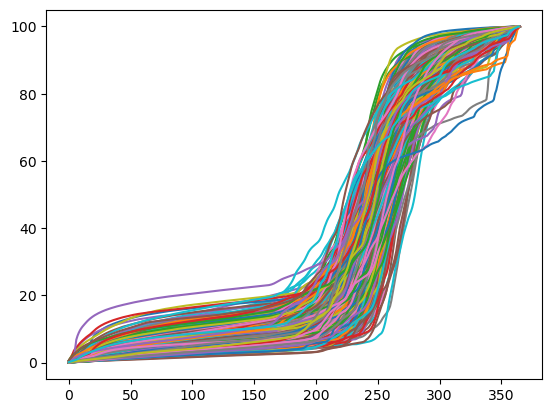

In [206]:
# calculate the length of the interquartile range for each WY at each site_no
high_elevation_df = pd.DataFrame(columns=high_elevation_daily_q.site_no.values, index=high_elevation_daily_q.isel(site_no=0).WY.to_pandas().unique())
for site in high_elevation_daily_q.site_no.values:
    tmp_ds = high_elevation_daily_q.sel(site_no=site)
    tmp_ds_filter = tmp_ds[['q_mm_day','WY']].where(tmp_ds.q_mm_day > 0, drop=True)
    for wy in tmp_ds_filter.WY.to_pandas().unique():
        high_elevation_df.loc[wy,site] = calc_iqr_length(tmp_ds_filter.where(tmp_ds_filter.WY==wy,drop=True))

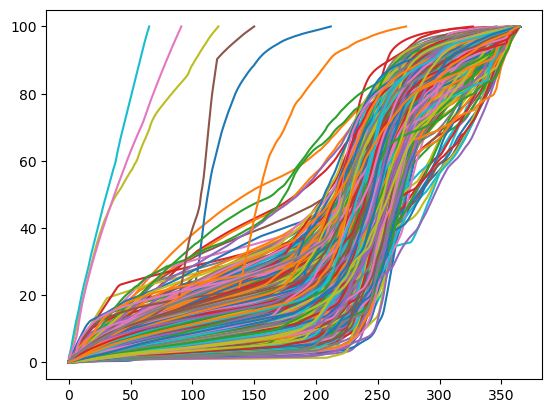

In [205]:
# calculate the length of the interquartile range for each WY at each site_no
mid_elevation_df = pd.DataFrame(columns=mid_elevation_daily_q.site_no.values, index=mid_elevation_daily_q.isel(site_no=0).WY.to_pandas().unique())
for site in mid_elevation_daily_q.site_no.values:
    tmp_ds = mid_elevation_daily_q.sel(site_no=site)
    tmp_ds_filter = tmp_ds[['q_mm_day','WY']].where(tmp_ds.q_mm_day > 0, drop=True)
    for wy in tmp_ds_filter.WY.to_pandas().unique():
        mid_elevation_df.loc[wy,site] = calc_iqr_length(tmp_ds_filter.where(tmp_ds_filter.WY==wy,drop=True))

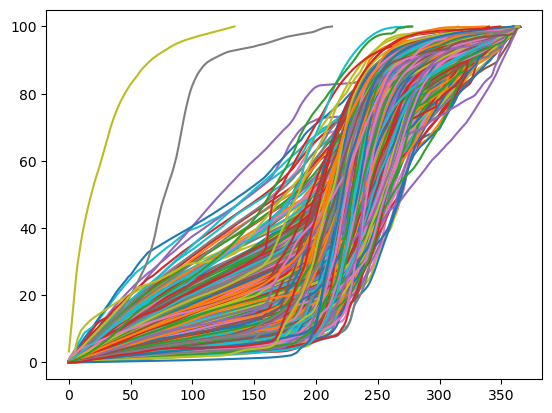

In [204]:
# calculate the length of the interquartile range for each WY at each site_no
low_elevation_df = pd.DataFrame(columns=low_elevation_daily_q.site_no.values, index=low_elevation_daily_q.isel(site_no=0).WY.to_pandas().unique())
for site in low_elevation_daily_q.site_no.values:
    tmp_ds = low_elevation_daily_q.sel(site_no=site)
    tmp_ds_filter = tmp_ds[['q_mm_day','WY']].where(tmp_ds.q_mm_day > 0, drop=True)
    for wy in tmp_ds_filter.WY.to_pandas().unique():
        low_elevation_df.loc[wy,site] = calc_iqr_length(tmp_ds_filter.where(tmp_ds_filter.WY==wy,drop=True))

In [240]:
# filter out the 5% and 95% percentiles of each columnn for the low_elevation_df
low_elevation_df_filtered = low_elevation_df.apply(lambda x: x[(x>=x.quantile(.05)) & (x<=x.quantile(.95))], axis=0)
# filter out the 5% and 95% percentiles of each columnn for the mid_elevation_df
mid_elevation_df_filtered = mid_elevation_df.apply(lambda x: x[(x>=x.quantile(.05)) & (x<=x.quantile(.95))], axis=0)

conf = 0.05

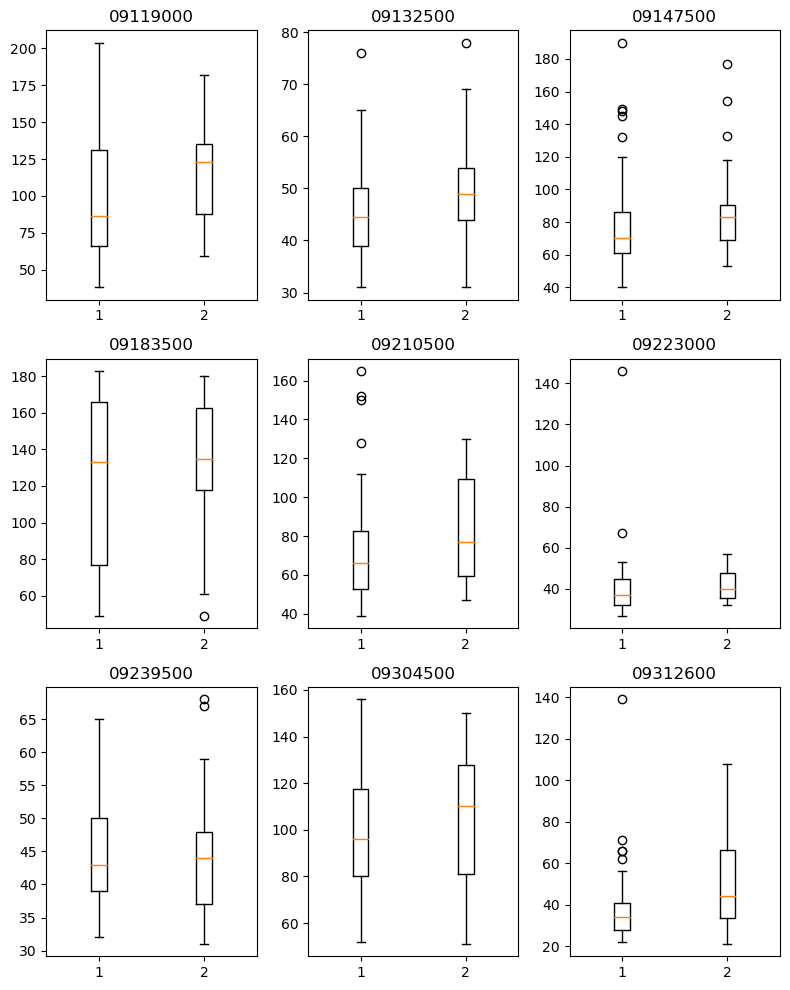

In [286]:
low_iqr_length_ttest = pd.DataFrame(index=low_elevation_df_filtered.columns, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
fig, axs = plt.subplots(3,3, figsize=(8,10), tight_layout=True)
axs = axs.ravel()
    
for i,site in enumerate(low_elevation_df.columns):
    single_site_pre = low_elevation_df[site].dropna().loc[:1999]
    single_site_post = low_elevation_df[site].dropna().loc[2000:]
    # create boxplot of single_site_pre and single_site_post
    axs[i].boxplot([single_site_pre, single_site_post]) 
    axs[i].set_title(site)
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_iqr_length_ttest.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        low_iqr_length_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        low_iqr_length_ttest.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            low_iqr_length_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_iqr_length_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_iqr_length_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post.values.astype(int),single_site_pre.values.astype(int), alternative='greater')
        low_iqr_length_ttest.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value  < conf:
            low_iqr_length_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_iqr_length_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

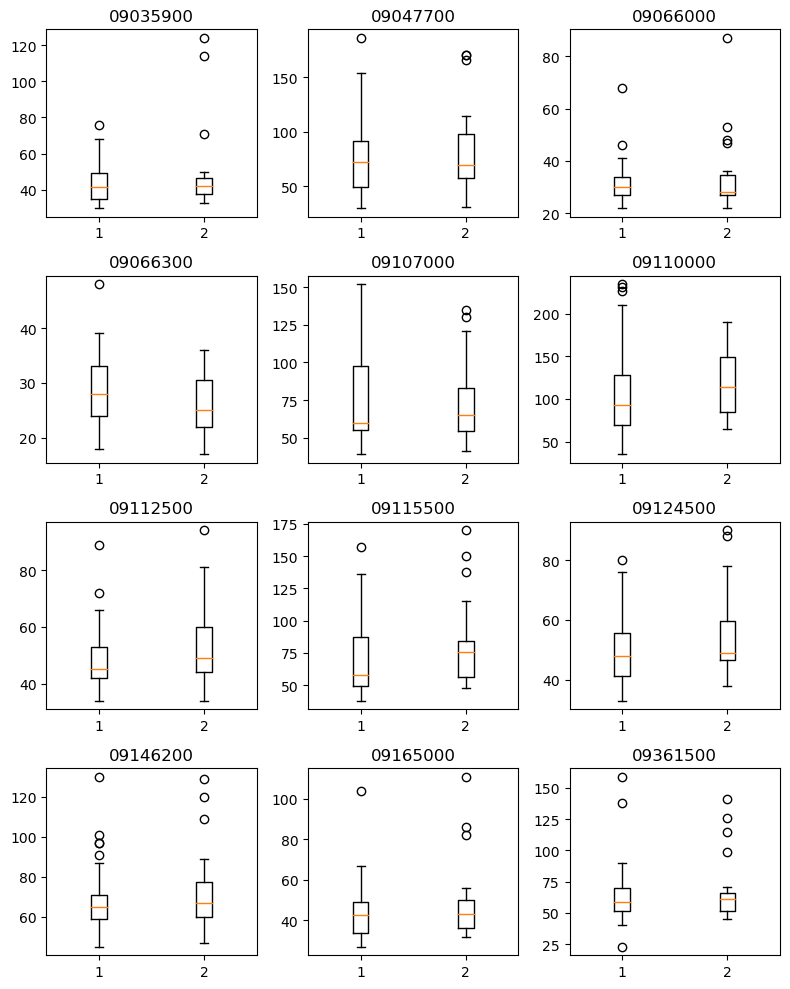

In [285]:
mid_iqr_length_ttest = pd.DataFrame(index=mid_elevation_df_filtered.columns, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
fig, axs = plt.subplots(4,3, figsize=(8,10), tight_layout=True)
axs = axs.ravel()
    
for i,site in enumerate(mid_elevation_df.columns):
    single_site_pre = mid_elevation_df[site].dropna().loc[:1999]
    single_site_post = mid_elevation_df[site].dropna().loc[2000:]
    # create boxplot of single_site_pre and single_site_post
    axs[i].boxplot([single_site_pre, single_site_post]) 
    axs[i].set_title(site)
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_iqr_length_ttest.loc[site,'Shapiro-Wilke p'] = p

    if p > 1-conf:
        mid_iqr_length_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_iqr_length_ttest.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_iqr_length_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_iqr_length_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_iqr_length_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post.values.astype(int),single_site_pre.values.astype(int), alternative='greater')
        mid_iqr_length_ttest.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_iqr_length_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_iqr_length_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

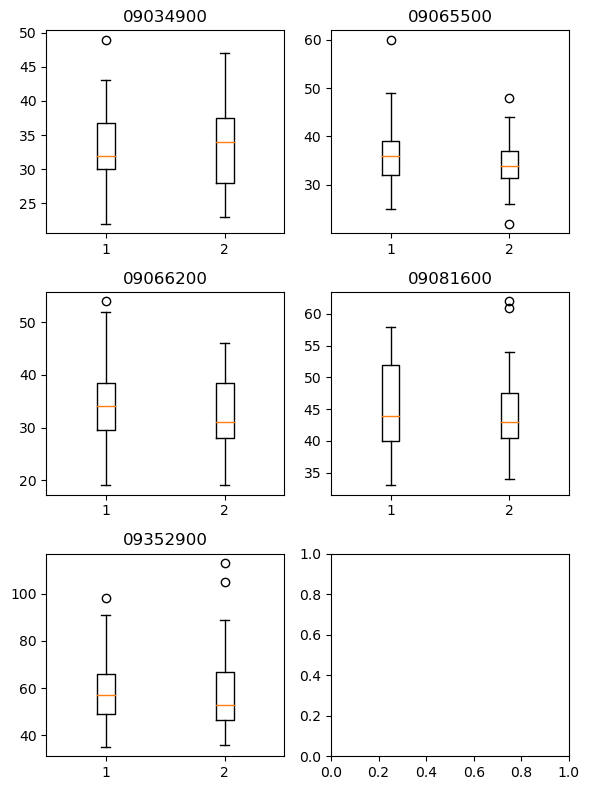

In [283]:
high_iqr_length_ttest = pd.DataFrame(index=high_elevation_df.columns, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
fig, axs = plt.subplots(3,2, figsize=(6,8), tight_layout=True)
axs = axs.ravel()
    
for i,site in enumerate(high_elevation_df.columns):
    single_site_pre = high_elevation_df[site].dropna().loc[:1999]
    single_site_post = high_elevation_df[site].dropna().loc[2000:]
    # create boxplot of single_site_pre and single_site_post
    axs[i].boxplot([single_site_pre, single_site_post]) 
    axs[i].set_title(site)
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_iqr_length_ttest.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        high_iqr_length_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        high_iqr_length_ttest.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            high_iqr_length_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_iqr_length_ttest.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_iqr_length_ttest.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post.values.astype(int),single_site_pre.values.astype(int), alternative='greater')
        high_iqr_length_ttest.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_iqr_length_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_iqr_length_ttest.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'